1000


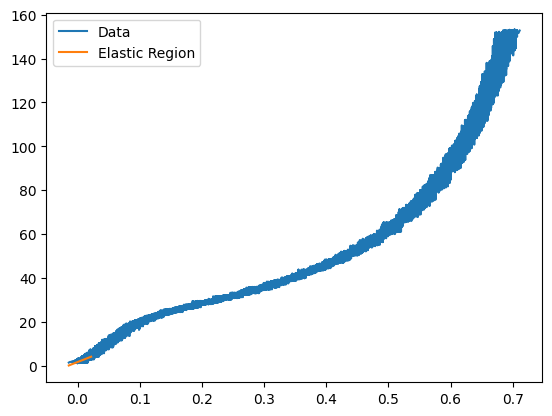

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#data with unknown naming convention
Auto_noheating_17wt_3_1 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-1-240212_02122024_180801.csv')
Auto_noheating_17wt_3_2 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-2-240212_02122024_181028.csv')
Auto_noheating_17wt_3_3 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-3-240212_02122024_181307.csv')
Auto_noheating_17wt_3_4 = pd.read_csv('Data/Compression Sample NH 10, 12, 15, 17 batch 3/AutoNoheating-17-3-4-240212_02122024_181657.csv')

data_list_17_3 = [Auto_noheating_17wt_3_1, Auto_noheating_17wt_3_2, Auto_noheating_17wt_3_3, Auto_noheating_17wt_3_4]
thickness_17_3 = [110,105,105,105]



#original/simplified 
def consolidate_data(data_list, thickness_info = True, thickness_list = None, cut_off_load = 2):
    # convert in to um
    for i in range(len(data_list)):
        data_list[i]['S:LVDT (um)'] = data_list[i]['S:LVDT (in)'] * 25.4 * 1000
        # create stress column which is load / area, the area is 19.635 mm^2
        data_list[i]['stress (bar)'] = data_list[i]['Ch:Load (N)'] / 19.635 *10

    if thickness_info:
        thickness = thickness_list
        x_axis = 'strain'
        x_axis_label = 'Strain'
        # convert in to um
        for i in range(len(data_list)): 
            # create strain column which is displacement / thickness, the thickness is shown above
            data_list[i]['strain'] = data_list[i]['S:LVDT (um)'] / thickness[i]
    else:
        x_axis = 'S:LVDT (um)'
        x_axis_label = 'Displacement (um)'
    data_list_cleaned = []
   
    # Plot these in the same graph to compare them
    plt.figure(figsize=(8, 6))
    for i in range(len(data_list)):
        data_name = namestr(data_list[i], globals())
        data = data_list[i][data_list[i]['Ch:Load (N)'] > cut_off_load]
        data = data.loc[:data['Ch:Load (N)'].idxmax()]
        # shift the data so that the first point is at 0 in 'S:LVDT (in)'
        data[x_axis] = data[x_axis] - data[x_axis].iloc[0]
        data_list_cleaned.append(data)
        plt.plot(data[x_axis], data['stress (bar)'], label=data_name)
    plt.xlabel(x_axis_label)
    plt.ylabel('Stress (bar)')
    plt.legend(loc='upper left')
    plt.show()
    # concatenate all the data into one dataframe
    data_all = pd.concat(data_list_cleaned, ignore_index=True)
    # sort the values by strain
    data_all = data_all.sort_values(by=x_axis) 
    return data_all

R = 1
model = LinearRegression()
for i in range(1000, len(data_all['stress (bar)'])):
    x = data_all[['strain']][:i+1]
    y = data_all[['stress (bar)']][:i+1]
    model.fit(x, y)
    y_pred = model.predict(x)
    R = r2_score(y, y_pred)
    if R < 0.75:
        print(i)
        break

plt.plot(data_all['strain'], data_all['stress (bar)'], label = "Data")
plt.plot(x,y_pred, label = "Elastic Region")
plt.legend()
plt.show()